<a href="https://colab.research.google.com/github/1ucky40nc3/girlsday/blob/copy_paste/intro_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Licensed unter the Apache License, Version 2.0
# https://github.com/1ucky40nc3/girlsday/blob/main/LICENSE

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/1ucky40nc3/girlsday/blob/main/machine_vision.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/1ucky40nc3/girlsday/blob/main/machine_vision.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

##1. Image classification (supervised) - ***Cat or Dog?***

In [2]:
# @title References
# https://www.tensorflow.org/tutorials/images/classification
# https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=ca
# https://www.tensorflow.org/datasets/keras_example

### Steps

1.   Aquire a dataset
2.   Preprocess the data
3.   Build the CNN
4.   Train the CNN
5.   Test the CNN



###1. Aquire a dataset

In [13]:
# @title Download and prepare the dataset for learning

import tensorflow_datasets as tfds
import tensorflow as tf

dataset, dataset_info = tfds.load(
    "cats_vs_dogs", 
    split="train",
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

TARGET_HEIGHT = 256
TARGET_WIDTH = 256

SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 32

def resize_img_with_pad(image, label):
    """Resizes and pads an image to a target width and height."""
    return tf.image.resize_with_pad(image, TARGET_HEIGHT, TARGET_WIDTH), label

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32` to [0, 1]."""
    return tf.cast(image, tf.float32) / 255, label

dataset = dataset.map(
    resize_img_with_pad,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
dataset = dataset.map(
    normalize_img,
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

Number_Train_Samples = 2000 #@param {type:"slider", min:100, max:23262, step:100}
Number_Test_Samples = 200 #@param {type:"slider", min:10, max:3000, step:10}

train_dataset = dataset.skip(Number_Test_Samples).take(Number_Train_Samples)
test_dataset = dataset.take(Number_Test_Samples)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

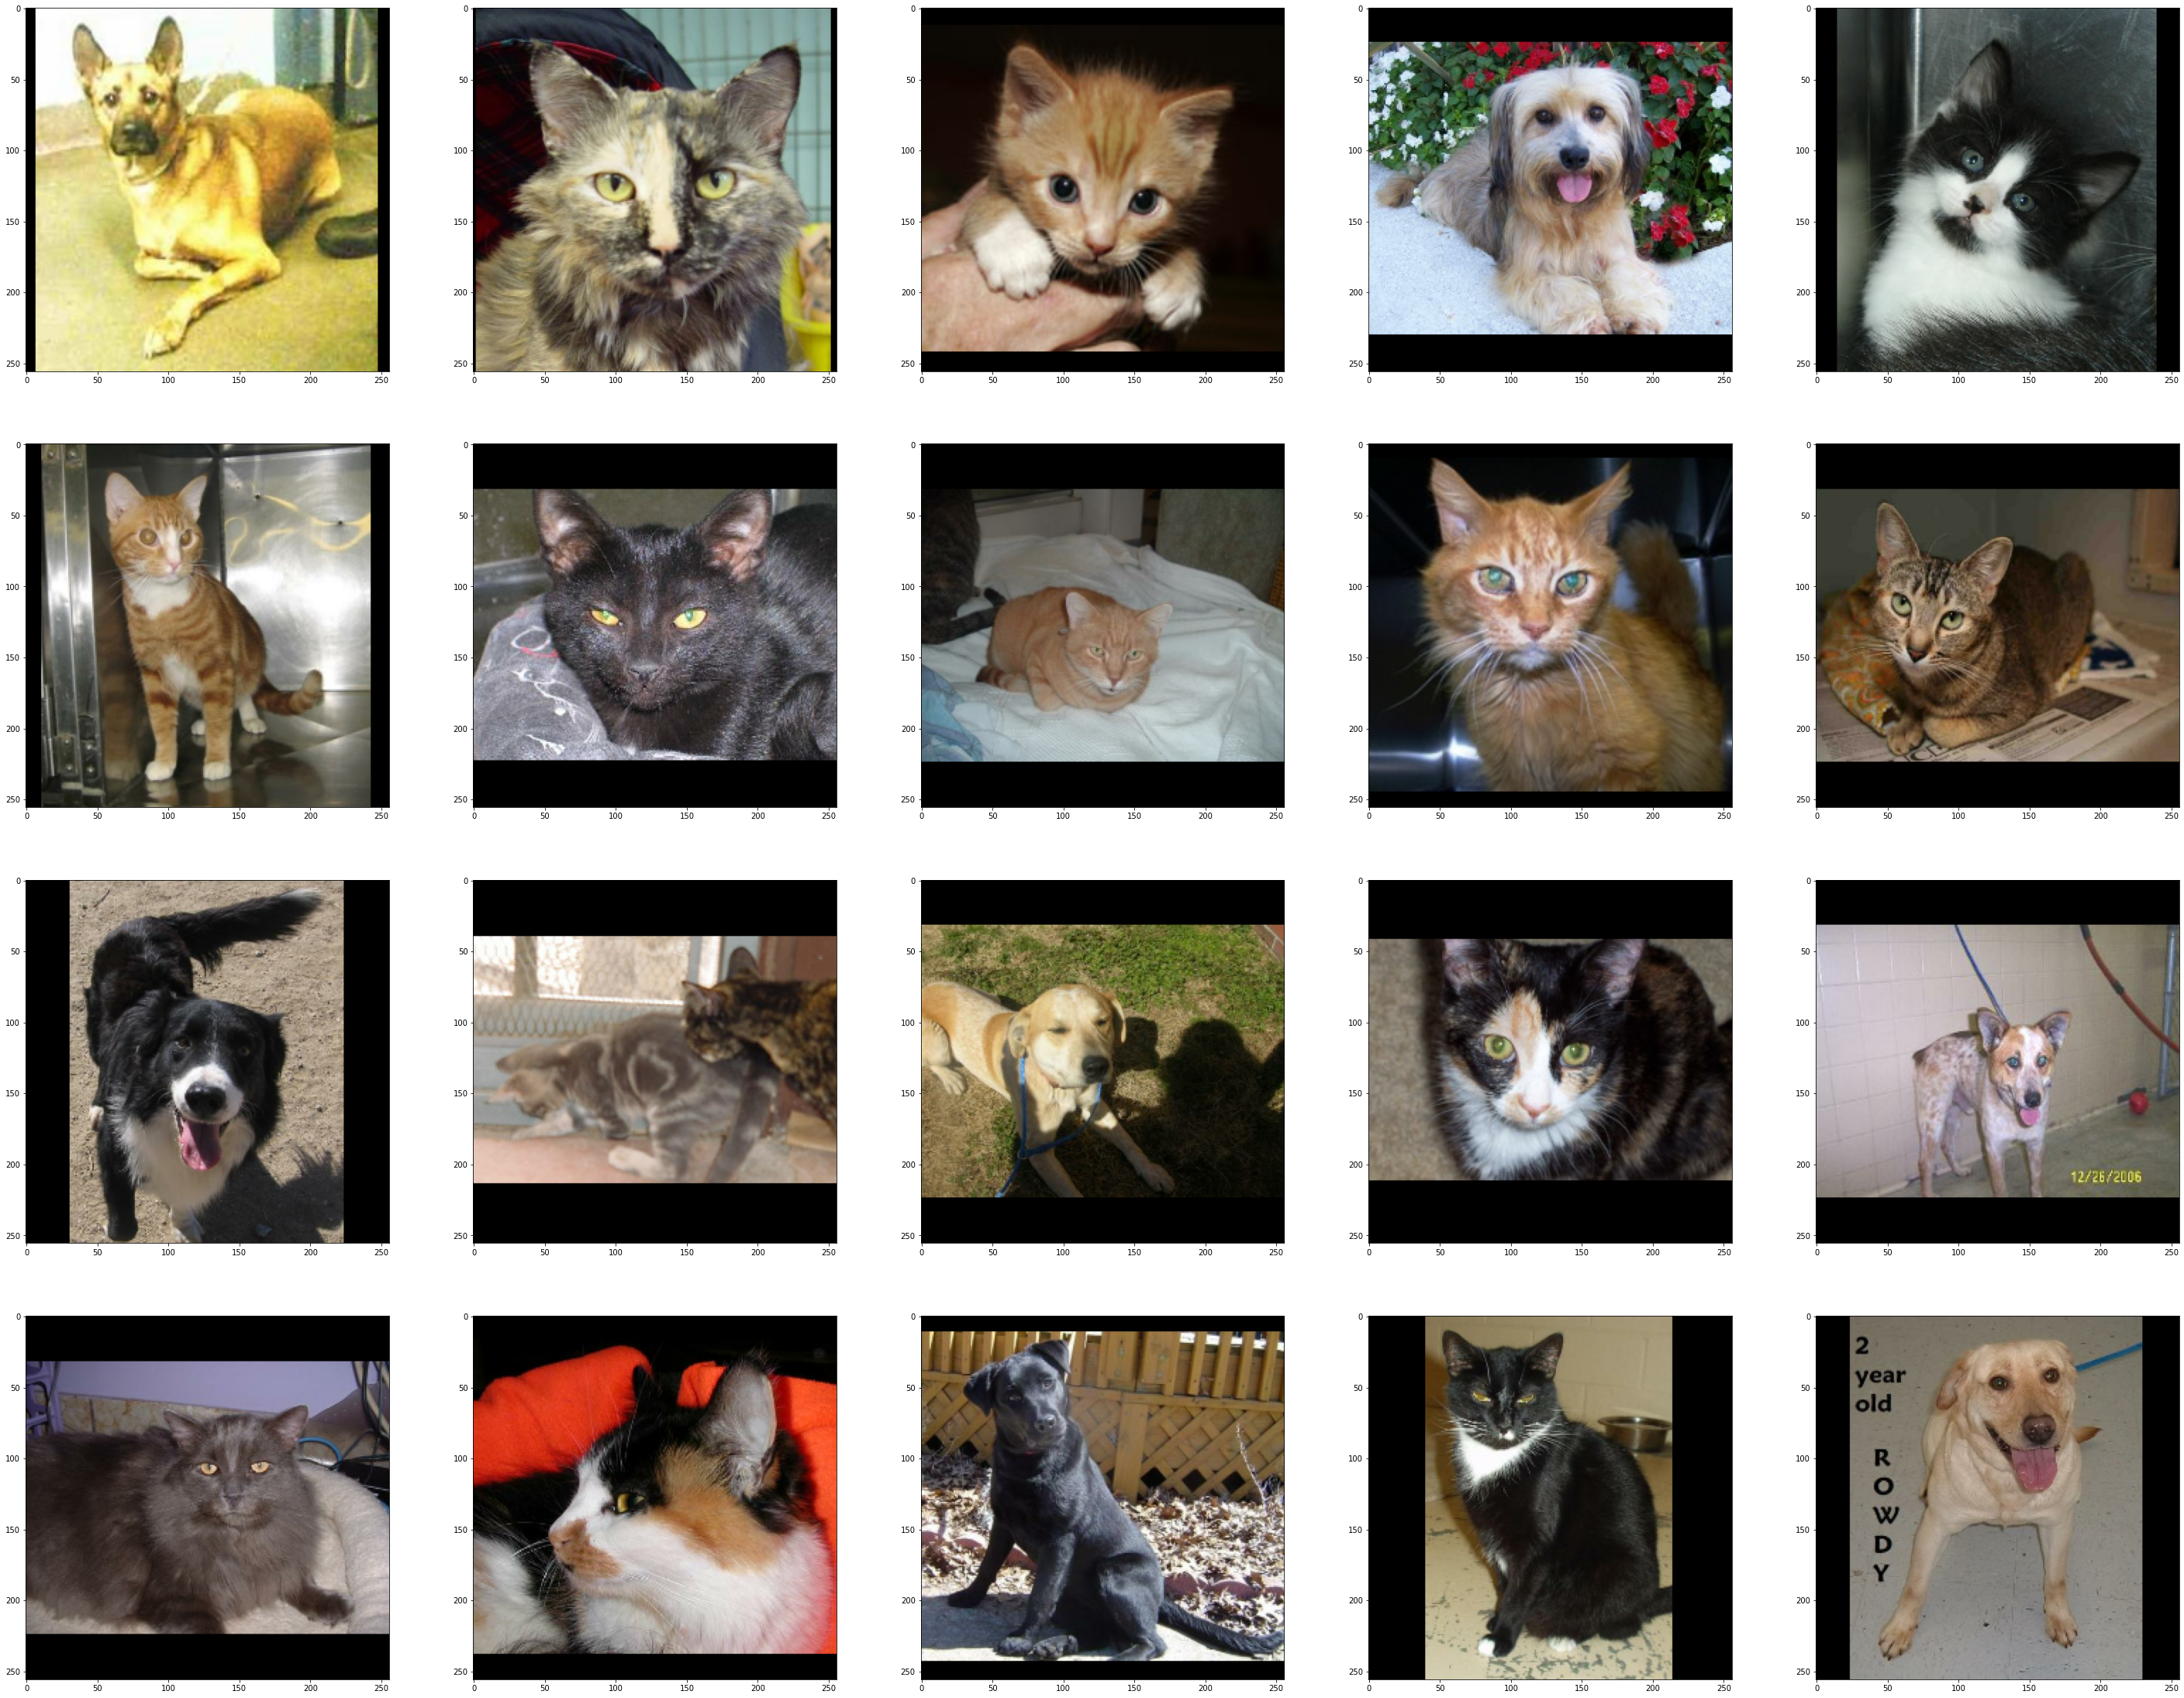

In [10]:
# @title Show samples from the dataset
%matplotlib inline

Number_Samples = 20 #@param {type:"slider", min:1, max:20, step:1}

import math
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 50))

def show_images(images):
    dim = int(math.sqrt(Number_Samples)) + 1

    for i, image in enumerate(images):
        plt.subplot(dim, dim, i + 1)
        plt.imshow(image[0])

samples = dataset.take(Number_Samples)

show_images(samples)

###2. Prepare Neural Networks for training

In [ ]:
# @title Define the Neural Networks

def generate_classifier(
    input_shape: tuple,
    num_conv_layers: int,
    num_dense_layers: int,
    output_dim: int,
    conv_kernel_size: int=5, 
    conv_padding: str="same", 
    conv_activation: str="relu",
    dense_activation: str="relu",
) -> tf.keras.models.Sequential:
    layers = []

    # Append the specified amount of Conv2D layers
    # with the given attributes to the list of layers.
    # Additionally add MaxPooling2D.
    for i in range(num_conv_layers):
        # Add the input_shape parameter to the first layer.
        kwargs = {
            "filters": 16*(i + 1),
            "kernel_size": conv_kernel_size,
            "padding": conv_padding,
            "activation": conv_activation,
        }

        if i == 0:
            kwargs["input_shape"] = input_shape
        
        layers.append(tf.keras.layers.Conv2D(**kwargs))
        layers.append(tf.keras.layers.MaxPooling2D())

    # Add Flatten layer to connect Conv2D to Dense layers.
    layers.append(tf.keras.layers.Flatten())

    # Add all Dense layers except the output layer.
    if num_dense_layers > 1:
        for i in range(1, num_dense_layers - 1):
            layers.append(
                tf.keras.layers.Dense(128//i, activation=dense_activation)
            )
    
    # Add the output layer to the list of layers.
    layers.append(
        tf.keras.layers.Dense(output_dim, activation="sigmoid")
    )

    # Wrap the layers into a Sequential model.
    classifier = tf.keras.models.Sequential(layers)

    # Compile the model with the Adam optimizer
    # and Binary Crossentroy Loss.
    classifier.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return classifier

Number_Classifiers = 2 #@param {type:"slider", min:1, max:10, step:1}
Base_Layer_Number_Conv2Ds = 1 #@param {type:"slider", min:1, max:10, step:1}
Increase_Layer_Number_Conv2Ds = 1 #@param {type:"slider", min:0, max:10, step:1}
Base_Layer_Number_Denses = 1 #@param {type:"slider", min:1, max:10, step:1}
Increase_Layer_Number_Denses = 1 #@param {type:"slider", min:0, max:10, step:1}

classifiers = []

for i in range(Number_Classifiers):
    classifier = generate_classifier(
        input_shape=(256, 256, 3), 
        num_conv_layers=Base_Layer_Number_Conv2Ds + (i*Increase_Layer_Number_Conv2Ds), 
        num_dense_layers=Increase_Layer_Number_Denses + (i*Increase_Layer_Number_Denses), 
        output_dim=1,
    )
    
    classifier.summary()
    print()

    classifiers.append(classifier)

###4. Train the Neural Networks on the Dataset

In [ ]:
# @title Load Statistics and Start Training

%load_ext tensorboard
import datetime
import os

!rm -r classifier_logs

classifier_logdir = os.path.join(
    "classifier_logs", 
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    classifier_logdir, histogram_freq=1)

%tensorboard --logdir classifier_logs

EPOCHS = 10

for classifier in classifiers:
    classifier_logdir = os.path.join(
        f"classifier_logs/{classifier.name}", 
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
    )  

    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        classifier_logdir, histogram_freq=1)

    classifier.fit(
        train_dataset, 
        epochs=EPOCHS, 
        validation_data=test_dataset,
        callbacks=[tensorboard_callback],
    )

###5. Test the Neural Networks